# An attempt to flag saturated stars in SM data

In [3]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from astropy.io import fits
import astroscrappy

In [5]:
from matplotlib.colors import LogNorm

In [6]:
import scipy.ndimage as ndimage

Grab one dataset

In [31]:
sourcefile=("../../datasets/sif_fits/2015-04-03/SIF_PROCESSING_CCD_ROW_3_SM1_OBMT_START_45028212999616700_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-07-03/SIF_PROCESSING_CCD_ROW_2_SM1_OBMT_START_52911899999459900_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-07-03/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_52953386000234300_CDP_NONE.fits")

hdulist = fits.open(sourcefile)
hdulist.info()
# Gaia SM images are binned by 2 in AC direction( hence AC dim = 990 )
# Gaia SM images are binned by 2 in AL direction( hence AL dim = 2543 )

Filename: ../../datasets/sif_fits/2015-04-03/SIF_PROCESSING_CCD_ROW_3_SM1_OBMT_START_45028212999616700_CDP_NONE.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      19   (990, 2542)   int16 (rescales to uint16)   
  1  AC_COORDINATES  ImageHDU        11   (990, 2542)   int16   
  2  AC_BINNING  ImageHDU        11   (990, 2542)   int16   
  3  TDI_TTAG    ImageHDU         9   (2542,)   int64   
  4  CI_BIT      ImageHDU         9   (2542,)   uint8   
  5  TDI_GATE    ImageHDU         9   (2542,)   int16   
  6  IDLE_BIT    ImageHDU         9   (2542,)   uint8   
  7  TEST_PATTERN_BIT  ImageHDU         9   (2542,)   uint8   
  8  OPEXIT_BIT  ImageHDU         9   (2542,)   uint8   
  9  STATUS_BIT  ImageHDU         9   (2542,)   int32   
 10  OBMT        ImageHDU         9   (2542,)   int64   


In [32]:
gain = 3.853  # just using the one from the BAM SIFs - this could be totally different!
readnoise = 2*gain

In [33]:
source = hdulist[0].data
hdulist.close()

(2542, 990)


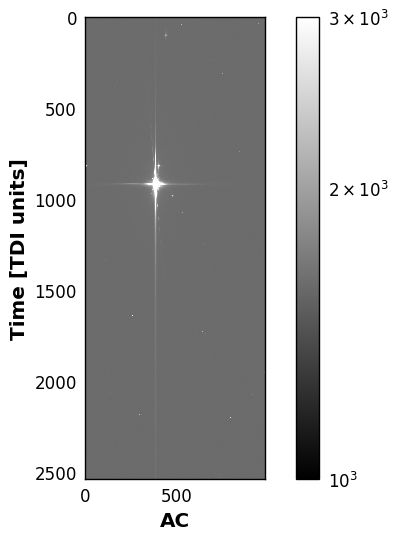

In [34]:
print(source.shape)

#image=np.flip(np.rot90(source,1),0) # this should follow the normal gaia convention
image=source         # reading coordinates is easier here...
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(image, cmap='gray', norm=LogNorm(),vmin=1e3,vmax=3e3)
plt.colorbar(orientation="vertical")
plt.grid(False)

In [35]:
# what is the center of mass?

cm = ndimage.center_of_mass(source)
print(cm)

cmx = int(np.rint(cm[0]))
cmy = int(np.rint(cm[1]))

(1264.4644739754767, 492.72147744890628)


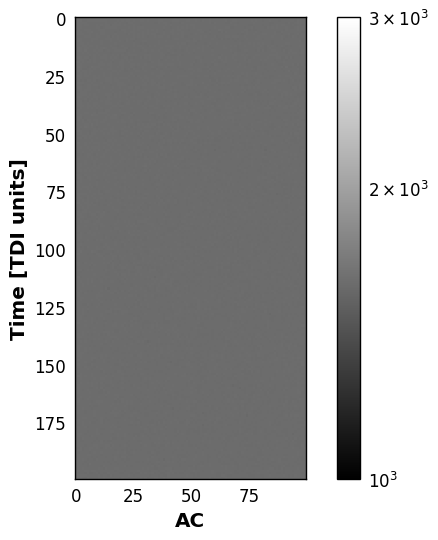

In [36]:
image=source         # reading coordinates is easier here...
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(image[(cmx-100):(cmx+100),(cmy-50):(cmy+50)], cmap='gray', norm=LogNorm(),vmin=1e3,vmax=3e3)
plt.colorbar(orientation="vertical")
plt.grid(False)

Just the center of mass does not seem to work well. How about we threshold before?

In [37]:
#thresh = np.mean(source) # use the mean - this is affected by outliers
thresh = 65535           # try to just look for saturation

threshmap = np.copy(source)
threshmap[threshmap<thresh] = 0

cm = ndimage.center_of_mass(threshmap)
print(cm)

cmx = int(np.rint(cm[0]))
cmy = int(np.rint(cm[1]))

(917.81889763779532, 391.27952755905511)


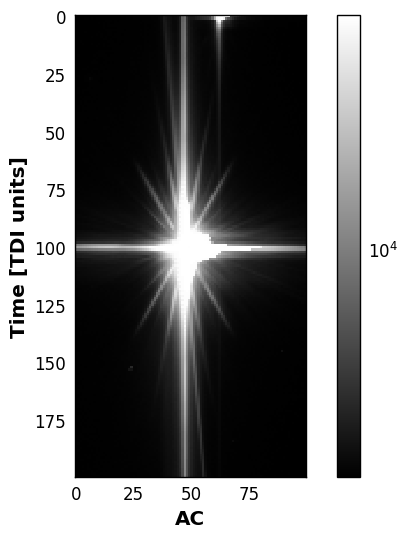

In [38]:
image=source         # reading coordinates is easier here...
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(image[(cmx-100):(cmx+100),(cmy-50):(cmy+50)], cmap='gray', norm=LogNorm())
plt.colorbar(orientation="vertical")
plt.grid(False)

Using the mean or just picking the saturated pixels seems to work well for these cases.

The question is: what do we do if there are multiple saturated stars?

In [39]:
satmap = np.logical_and(source,source>=60000)

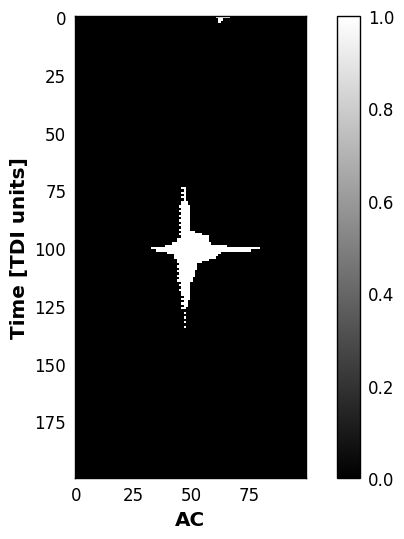

In [40]:
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(satmap[(cmx-100):(cmx+100),(cmy-50):(cmy+50)], cmap='gray')
plt.colorbar(orientation="vertical")
plt.grid(False)

Morphologically speaking, the saturated stars always seem to have an extended streak towards higher AC which is not connected by fully saturated (i.e. at ADU=65535) pixels. Were that not the case, I could just use labelling from ndimages...

However, I could probably pick some safe threshold (say 60000) where everything is connected! I could then use labelling to identify individual stars, determine their centers of mass and mask them!

So the approach could be:

- Make a mask of everything above LIMIT samples
  - (if there is nothing in that mask, abort)
- Extract everything that looks connected using label from ndimages
- Throw away cosmics, if present
- Determine the center of mass of these regions - perhaps sampling from a larger region
- Determine the size of these regions (distance CM to outermost pixel above LIMIT)
- Mask them - either a box or PSF

The choice of LIMIT will be very important!

What we need to look out for here is that we don't find any cosmics! Could we reject masked regions that are too small?

This would then still throw away all cosmics that saturate the detector, but those would be ignored by scrappy anyways!

In [93]:
# Everything in one function

def sm_extract_stars(image, threshold):
    """
    Extract saturated stars out of an SM image.

    This constructs a map of pixels above threshold, labels all connected pixels as one object and rejects all objects that do not contain at least one saturated pixel (i.e. above 65535 ADU).
    
    Returns a list of slice-tuples (as generated by scipy.ndimages.find_objects) of identified stars.
    If no stars are detected, the list will be empty.
    """
    import numpy as np
    from scipy.ndimage import generate_binary_structure
    from scipy.ndimage.morphology import binary_dilation
    from scipy.ndimage.measurements import label, find_objects
    
    # if nothing is greater equal the threshold, return an empty list
    if (np.max(image)<threshold):
        return []
    
    # mask of pixels above threshold
    satmap = np.logical_and(source,source>=threshold)
    # dilate it - sometimes, pixel values fluctuate around the threshold
    satmap = binary_dilation(satmap,iterations=1)
    # labelling all connected pixels
    (starlabels, nstars) = label(satmap,structure=(np.ones((3,3))))

    # object extraction based on labels
    stars = find_objects(starlabels)
    
    # return all "stars" that have at least one sample above 65535
    return [s for s in stars if np.max(source[s])==65535]
    #return stars

2


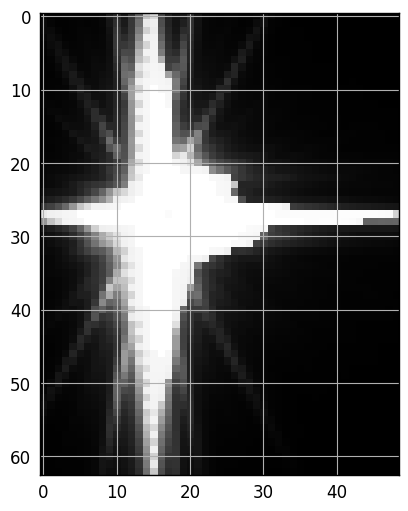

In [96]:
stars = sm_extract_stars(source, 60000)

plt.imshow(source[stars[1]],cmap="gray")

print(len(stars))

In [103]:
# can we determine the PSF core even though we only sample parts of the star?

teststar = stars[1]

x0 = teststar[0].start
x1 = teststar[0].stop
y0 = teststar[1].start
y1 = teststar[1].stop

extract = source[teststar]

cm = ndimage.center_of_mass(extract)
print(cm)

cmx = int(np.rint(cm[0])) + x0
cmy = int(np.rint(cm[1])) + y0

(29.428546595863782, 18.271979614052828)


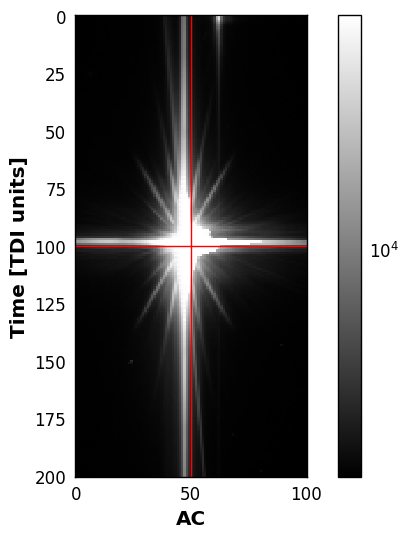

In [104]:
image=source         # reading coordinates is easier here...
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(image[(cmx-100):(cmx+101),(cmy-50):(cmy+51)], cmap='gray', norm=LogNorm())
plt.colorbar(orientation="vertical")
plt.plot(range(101),np.ones(101)*100,color='r')
plt.plot(np.ones(201)*50,range(201),color='r')
plt.grid(False)

To get the center of the PSF, we could actually use its non-spherical nature:

In [101]:
teststar = stars[1]

x0 = teststar[0].start
x1 = teststar[0].stop
y0 = teststar[1].start
y1 = teststar[1].stop

cx = int((np.argmax(source[x0:x1,y0]) + np.argmax(source[x0:x1,y1]))/2.) + x0
cy = int((np.argmax(source[x0,y0:y1]) + np.argmax(source[x1,y0:y1]))/2.) + y0
# other idea may be a weighted sum (so center of mass) instead of the argmax
# of course, this may be vulnerable to outside interference, so to speak

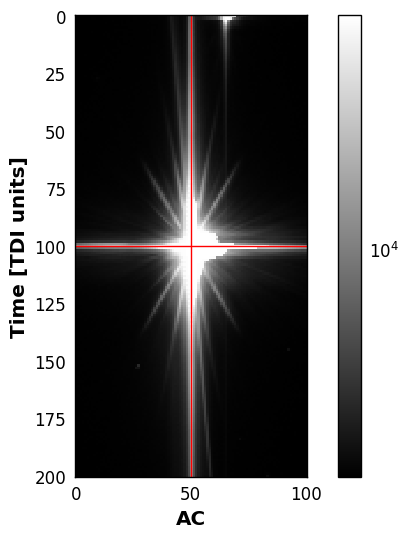

In [102]:
image=source         # reading coordinates is easier here...
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(image[(cx-100):(cx+101),(cy-50):(cy+51)], cmap='gray', norm=LogNorm())
plt.colorbar(orientation="vertical")
plt.plot(range(101),np.ones(101)*100,color='r')
plt.plot(np.ones(201)*50,range(201),color='r')
plt.grid(False)

Seems like that works!

Let's write a function, using the crosshair method

NOTE: IN THE FUNCTION, I SWAP X AND Y SUCH THAT X IS ROW, Y IS COLUMN

In [47]:
def sm_star_mask(image, stars, buffer_row=1,buffer_col=1):
    """
    Given an array of locations for stars, generate a mask for all stars in image.
    
    This computes the PSF center of the given slices by analyzing the PSF and adds a rectangle with the maximum distance in x (AC) and y (AL)
    This distance is multiplied by buffer_row and buffer_col respectively and will not exceed the image dimensions.
    """
    # image parameters
    import numpy as np
    from scipy.ndimage import center_of_mass
    ymax, xmax = image.shape
    ymax -= 1
    xmax -= 1
    
    # list of masks
    starmask = np.zeros(image.shape, dtype=bool)
    
    for star in stars:
        
        # bounding box of coordinates
        y0 = star[0].start
        y1 = star[0].stop
        x0 = star[1].start
        x1 = star[1].stop
        
        # center of psf, using its "wings" as a crosshair:
        cy = int((np.argmax(source[y0:y1,x0]) + np.argmax(source[y0:y1,x1]))/2.) + y0
        cx = int((np.argmax(source[y0,x0:x1]) + np.argmax(source[y1,x0:x1]))/2.) + x0
        
        # border distances from center of mass (symmetric for now)
        dx = int(np.rint(max([cx-x0, x1-cx])*buffer_col))
        dy = int(np.rint(max([cy-y0, y1-cy])*buffer_row))
        
        # bounding box of mask
        xm0 = max([0, cx-dx])
        xm1 = min([xmax, cx+dx])
        ym0 = max([0, cy-dy])
        ym1 = min([ymax, cy+dy])

        # set everything in the box to 1
        starmask[ym0:ym1,xm0:xm1] = True
        
    return starmask

In [48]:
smask = sm_star_mask(source,stars,buffer_row=2,buffer_col=1)

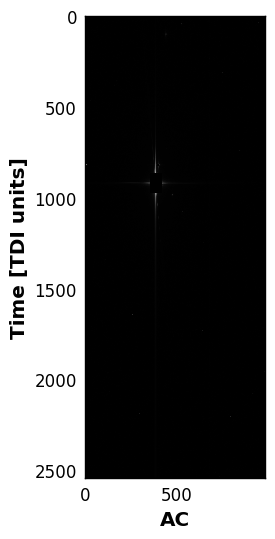

In [55]:
image=np.copy(source)         # reading coordinates is easier here...
image[smask==1]=np.median(source)
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(image, cmap='gray',norm=LogNorm())
plt.grid(False)

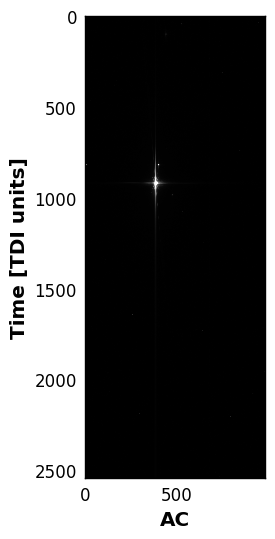

In [53]:
plt.ylabel('Time [TDI units]')
plt.xlabel('AC')
plt.imshow(source, cmap='gray',norm=LogNorm())
plt.grid(False)